In [10]:
import time
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.cluster import DBSCAN
import numpy as np

In [11]:
##################################################
####### define  functions 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


def Create_WaterSorption_isotherm(Sorption):
    if True:
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)
        
        for start,  end in zip(args, args[1:]):
            print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()
            
            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]
            
            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
    return isotherm_RHtarget_ads, [i for i in isotherm_adsorption], isotherm_RHtarget_des, [i for i in isotherm_desorption],  Sorption.data.time.max()- Sorption.data[split_index_ads[0]:split_index_ads[1]].time.min()




       time      temp      mass
0  0.020833  25.86967  8.882714
1  0.029167  25.87064  8.881851
2  0.037500  25.87240  8.881305
3  0.045833  25.87128  8.880914
4  0.054167  25.87201  8.879726
File ../DVS/isotherms/syloid_isotherm_25C-2021-03-19 23-03-21.xls read succesfull
[]
[0, 41880]
0 41880


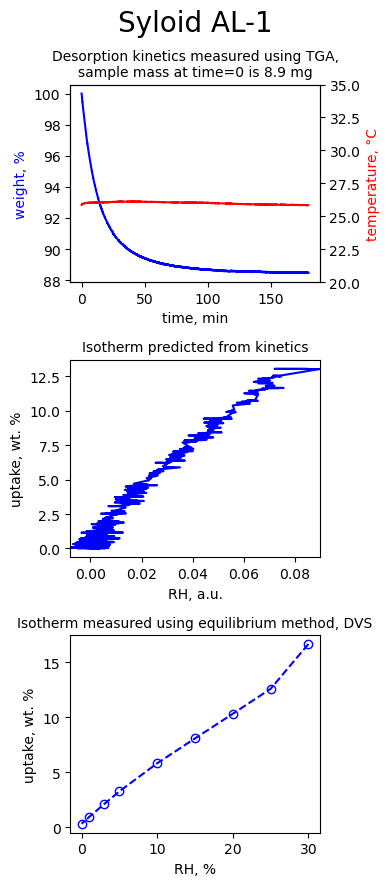

       time      temp      mass
0  0.012500  26.43551  8.956501
1  0.020833  26.43548  8.955956
2  0.029167  26.43618  8.955313
3  0.037500  26.43893  8.954761
4  0.045833  26.44124  8.954042
File 2_AAB-3-107_Isotherm-2020-07-15 12-43-44.xls read succesfull
[]
[0, 26668]
0 26668


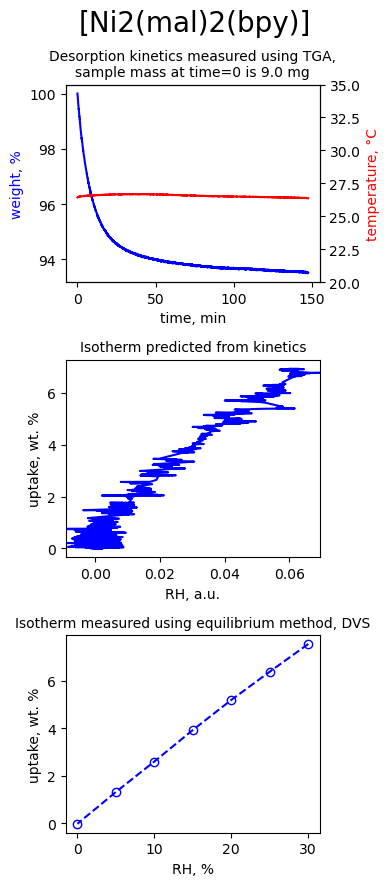

       time      temp      mass
0  0.012500  25.76382  7.058148
1  0.020833  25.76613  7.058140
2  0.029167  25.76840  7.058179
3  0.037500  25.76885  7.057929
4  0.045833  25.76891  7.057856
File ../DVS/isotherms/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx read succesfull
[]
[0, 158535]
0 158535


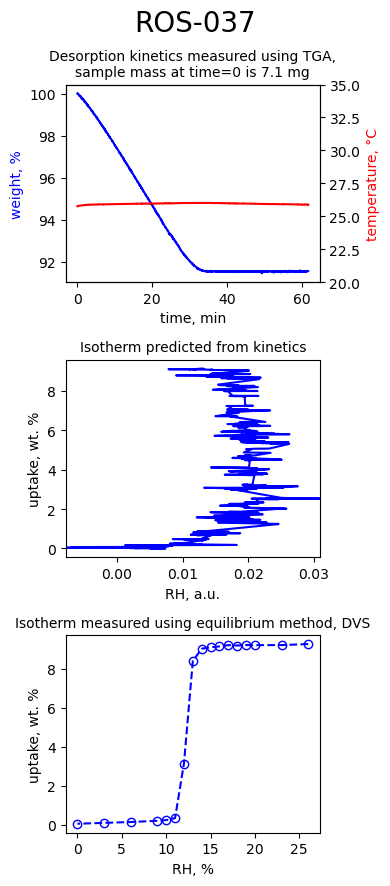

       time      temp      mass
0  0.012500  25.64939  9.043984
1  0.020833  25.65378  9.043462
2  0.029167  25.65434  9.043078
3  0.037500  25.65560  9.043018
4  0.045833  25.65757  9.042976
File ../DVS/isotherms/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx read succesfull
[]
[0, 69627]
0 69627


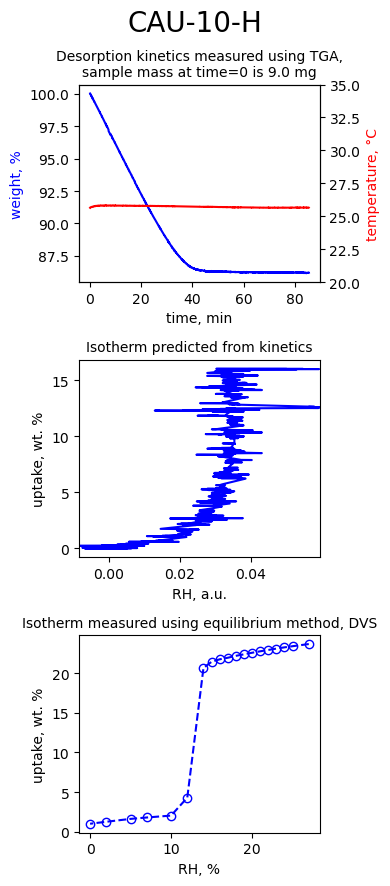

       time      temp      mass
0  0.012500  25.53594  11.49850
1  0.020833  25.53771  11.49837
2  0.029167  25.53835  11.49784
3  0.037500  25.53867  11.49709
4  0.045833  25.54172  11.49679
File ../DVS/isotherms/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls read succesfull
[]
[0, 64118]
0 64118


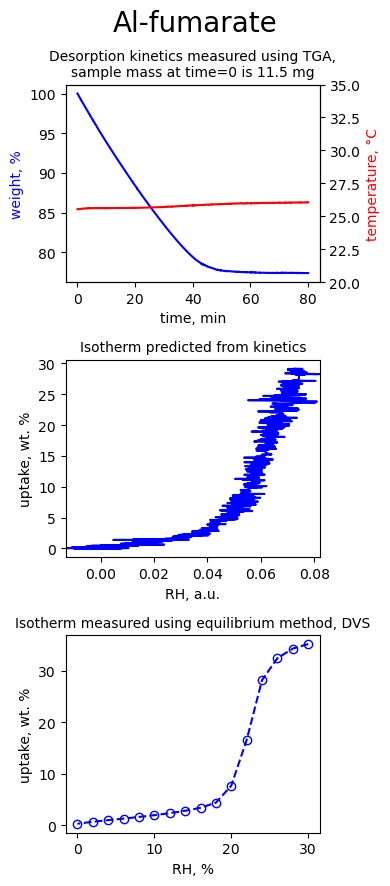

       time      temp      mass
0  0.045833  26.10220  10.71512
1  0.070833  26.10708  10.71349
2  0.095833  26.11265  10.71209
3  0.120833  26.11810  10.70939
4  0.145833  26.12404  10.70833
File ../DVS/isotherms/20191224_Zeoleite13X - Tue 24 Dec 2019 13-41-50.xlsx read succesfull
[]
[0, 103055]
0 103055


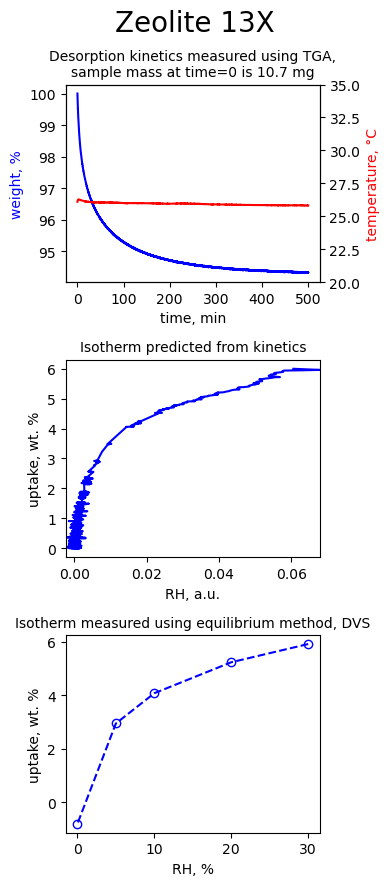

       time      temp      mass
0  0.045833  27.06156  25.19750
1  0.075000  27.06475  25.19617
2  0.104167  27.06899  25.19429
3  0.133333  27.07276  25.19294
4  0.162500  27.07450  25.19101
File ../DVS/isotherms/MolecularSieve3A_isotherm_27C-2022-08-14 21-28-21.xls read succesfull
[]
[0, 22168]
0 22168


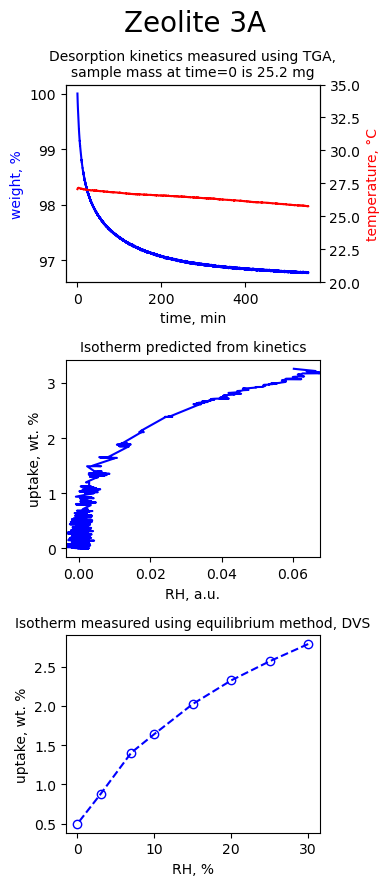

In [12]:
##################################################
####### main 
##################################################
filelist =  {'Syloid AL-1':{'kinetics':'Syloid_50-100um_hold25C.txt',
                        'isotherm':'../DVS/isotherms/syloid_isotherm_25C-2021-03-19 23-03-21.xls',
                           'RH':31,
                           },
             '[Ni2(mal)2(bpy)]':{'kinetics':'AAB-3-107_hold25C.txt',
                        'isotherm':'2_AAB-3-107_Isotherm-2020-07-15 12-43-44.xls',
                           'RH':30,
                           },
             'ROS-037':{'kinetics':'AAB_ROS-037_PureBatch_hold25C.txt',
                        'isotherm':'../DVS/isotherms/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx',
                       'RH':29,
                       },
             'CAU-10-H':{'kinetics':'CAU-10_NK-1-1531_50-100um_hold25C.txt',
                        'isotherm':'../DVS/isotherms/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx',
                        'RH':29,
                        },
             'Al-fumarate':{'kinetics':'Al-fum_NK-1-1521_hold25C.txt',
                        'isotherm':'../DVS/isotherms/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls',
                           'RH':31,
                           },
             'Zeolite 13X':{'kinetics':'Zeolite13X_hold25C.txt',
                        'isotherm':'../DVS/isotherms/20191224_Zeoleite13X - Tue 24 Dec 2019 13-41-50.xlsx',
                           'RH':30,
                           },
             'Zeolite 3A':{'kinetics':'Zeolite3A_hold25C_002.txt',
                        'isotherm':'../DVS/isotherms/MolecularSieve3A_isotherm_27C-2022-08-14 21-28-21.xls',
                           'RH':30,
                           },

             
            }

text_size = 10
window1 = 50
window2 = 50
path = '../../../../data/water_sorption/TGA/'
for material_name in filelist.keys():
    df = pd.read_csv(path+filelist[material_name]['kinetics'], skiprows=42, sep='\t', names = ['time', 'temp', 'mass'], encoding='iso-8859-1')
    print(df.head())
    
    fig, ax = plt.subplots(3, 1, figsize=(4, 9))
    fig.suptitle(material_name, fontsize=text_size*2)
    
    # uptake desorption
    try:
        w_ads = pd.DataFrame({'time':df.time, 
                              'uptake':df.mass,
                              'temp':df.temp
                              })
    except Exception as e:
        print(e)
        continue
    ax[0].plot(w_ads['time'],
                  w_ads['uptake']/w_ads['uptake'].max()*100,
                   c='b'
                  )

    ax[0].set_xlabel('time, min', fontsize=text_size)
    ax[0].set_ylabel('weight, %', fontsize=text_size, c='b')
    ax[0].tick_params(axis='x', labelsize=text_size)
    ax[0].tick_params(axis='y', labelsize=text_size)
    ax[0].set_title('Desorption kinetics measured using TGA,\nsample mass at time=0 is {0} mg'.format(round(df.mass[0], 1)), fontsize=text_size)
    ax_t = ax[0].twinx()
    ax_t.plot(w_ads['time'],
                  w_ads['temp'],
                  c='r',
             )
    ax_t.set_ylim([20, 35])
    ax_t.set_ylabel('temperature, °C', fontsize=text_size, c='r')
    ax_t.tick_params(axis='y', labelsize=text_size)
    
    # first derivative adsorption
    first_derivative_dwdt_ads = pd.DataFrame({'dwdt':(w_ads['uptake'].diff()/w_ads['time'].diff()).rolling(window=window1, min_periods=1).mean(),
                                              'uptake':w_ads['uptake']
                                              })

    # first derivative adsorption where second derivative is negatinve
    first_derivative_dwdt_dw_ads = pd.DataFrame({'dwdt_dw':(first_derivative_dwdt_ads['dwdt'].diff()/first_derivative_dwdt_ads['uptake'].diff()).rolling(window=window2, min_periods=1).mean(),
                                                 'uptake':first_derivative_dwdt_ads['uptake']
                                                 })
    def normalize(x):
        return (x-x.min())/(x.max()-x.min())
    X = np.array([[i[0], i[1]] for i in zip(normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['uptake']), normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['dwdt']))  ])
    clustering_ads = DBSCAN(eps=0.2, min_samples=1).fit(X)

    ### perform fitting/plot prediction
    try:       
        first_derivative_dwdt_ads['dwdt_scaled'] = first_derivative_dwdt_ads['dwdt']
        frames = [first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()][['uptake', 'dwdt_scaled']],
                 ]
        joined_first_derivative_dwdt = pd.concat(frames, sort=True)
        joined_first_derivative_dwdt = joined_first_derivative_dwdt.sort_values(by=['uptake'])
        #ax[0, 2].plot(joined_first_derivative_dwdt['uptake'], joined_first_derivative_dwdt['dwdt'])   
        ax[1].plot(-joined_first_derivative_dwdt['dwdt_scaled'], 
                    100*(joined_first_derivative_dwdt['uptake']-joined_first_derivative_dwdt['uptake'].min())/joined_first_derivative_dwdt['uptake'].min(),
                     c='b',
                     )
        ax[1].set_xlabel('RH, a.u.', fontsize=text_size)
        ax[1].set_ylabel('uptake, wt. %', fontsize=text_size)
        ax[1].tick_params(axis='x', labelsize=text_size)
        ax[1].tick_params(axis='y', labelsize=text_size)
        ax[1].set_xlim([-joined_first_derivative_dwdt['dwdt_scaled'].max(), 
                        -joined_first_derivative_dwdt['dwdt_scaled'].min()])
        ax[1].set_title('Isotherm predicted from kinetics', fontsize=text_size)
    except Exception as e: 
        print(e)
        pass
    
    # plot experimental isotherm
    try:
        Sorption_isotherm = file_Sorption()
        Sorption_isotherm.read_file(path,filelist[material_name]['isotherm'])
        isotherm_RHtarget_ads, isotherm_adsorption, isotherm_RHtarget_des, isotherm_desorption, time1 = Create_WaterSorption_isotherm(Sorption_isotherm)
    
        exp_isotherm_ads = pd.DataFrame({'RH_ads':isotherm_RHtarget_ads, 
                                 'ads':isotherm_adsorption, })
        exp_isotherm_des = pd.DataFrame({'RH_des':isotherm_RHtarget_des, 
                                 'des':isotherm_desorption
                                })
        #RH_max = Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['RH_target'].max()
        RH_max=filelist[material_name]['RH']
        ax[2].plot(exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].RH_des, 
                   exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].des,
                   linestyle='dashed',
                   c='b'
                  )
        ax[2].scatter(exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].RH_des, 
                      exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].des,
                      facecolors='w', edgecolor='b',
                     )
        ax[2].set_ylabel('uptake, wt. %', fontsize=text_size)
        ax[2].set_xlabel('RH, %', fontsize=text_size)
        ax[2].tick_params(axis='x', labelsize=text_size)
        ax[2].tick_params(axis='y', labelsize=text_size)
        ax[2].set_title('Isotherm measured using equilibrium method, DVS', fontsize=text_size)

    except Exception as e: 
        print(e)
        pass
    
    plt.tight_layout()
    plt.savefig(material_name+'_fromTGA.png', dpi=300)
    plt.show()
